# Predicting Won/Dollar Exchange Rate

#### ** KAIST의 StandAlone Deeplearning에서 제공하는 코드를 참조하여 만든 코드입니다. **

## Loading Modules

In [25]:
import pandas as pd
import pandas_datareader.data as pdr
import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import argparse
from copy import deepcopy # Add Deepcopy for args
from sklearn.metrics import mean_absolute_error
import time
import scipy.signal
from sklearn.preprocessing import RobustScaler

import seaborn as sns 
import matplotlib.pyplot as plt

print(torch.__version__)
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

1.12.1+cu113
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['seed', 'partition']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Loading Dataset

### Data Preprocessing

In [49]:
from google.colab import files
myfile = files.upload()

Saving wondollarfinal.csv to wondollarfinal.csv


In [50]:
myfile

{'wondollarfinal.csv': b'\xef\xbb\xbf1172.50 ,1183.50 ,1179.75 ,1175.00 ,1170.10 ,1175.55 ,1204.50 ,1223.50 ,1241.75 ,1233.50 ,1215.00 ,1222.65 ,1224.90 ,1221.00 ,1216.00 ,1190.00 ,1188.50 ,1202.50 ,1207.50 ,1193.25 ,1185.85 ,1183.75 ,1167.40 ,1163.50 ,1155.00 ,1163.80 ,1185.50 ,1182.00 ,1207.50 ,1203.50 ,1199.50 ,1203.50 ,1200.00 ,1182.50 ,1191.00 ,1191.00 ,1203.00 ,1212.00 ,1215.50 ,1203.50 ,1205.00 ,1205.25 ,1199.50 ,1186.50 ,1170.00 ,1173.65 ,1159.00 ,1150.25 ,1132.65 ,1130.40 ,1132.10 ,1135.50 ,1137.50 ,1124.50 ,1127.50 ,1120.50 ,1129.50 ,1115.00 ,1129.00 ,1136.50 ,1120.00 ,1119.50 ,1117.25 ,1108.50 ,1105.25 ,1108.50 ,1111.10 ,1108.45 ,1109.75 ,1111.50 ,1113.25 ,1121.50 ,1135.00 ,1125.10 ,1115.00 ,1116.30 ,1119.25 ,1115.03 ,1118.50 ,1112.80 ,1112.80 ,1116.75 ,1115.50 ,1115.50 ,1115.05 ,1114.05 ,1105.50 ,1109.00 ,1119.85 ,1135.00 ,1115.15 ,1117.50 ,1130.50 ,1132.50 ,1136.50 ,1134.80 ,1135.50 ,1143.00 ,1189.50 ,1209.50 ,1190.50 ,1207.50 ,1237.15 ,1265.00 ,1262.50 ,1281.50 ,1273.50 ,

In [51]:
prac_data = str(myfile.values()).replace("dict_values([b'\\xef\\xbb\\xbf", '').replace(' ,,', ' ,').replace("'])", '').split(',')
float_lst = []
for item in prac_data:
    float_lst.append(float(item))
    
print(float_lst)
print(len(float_lst))

[1172.5, 1183.5, 1179.75, 1175.0, 1170.1, 1175.55, 1204.5, 1223.5, 1241.75, 1233.5, 1215.0, 1222.65, 1224.9, 1221.0, 1216.0, 1190.0, 1188.5, 1202.5, 1207.5, 1193.25, 1185.85, 1183.75, 1167.4, 1163.5, 1155.0, 1163.8, 1185.5, 1182.0, 1207.5, 1203.5, 1199.5, 1203.5, 1200.0, 1182.5, 1191.0, 1191.0, 1203.0, 1212.0, 1215.5, 1203.5, 1205.0, 1205.25, 1199.5, 1186.5, 1170.0, 1173.65, 1159.0, 1150.25, 1132.65, 1130.4, 1132.1, 1135.5, 1137.5, 1124.5, 1127.5, 1120.5, 1129.5, 1115.0, 1129.0, 1136.5, 1120.0, 1119.5, 1117.25, 1108.5, 1105.25, 1108.5, 1111.1, 1108.45, 1109.75, 1111.5, 1113.25, 1121.5, 1135.0, 1125.1, 1115.0, 1116.3, 1119.25, 1115.03, 1118.5, 1112.8, 1112.8, 1116.75, 1115.5, 1115.5, 1115.05, 1114.05, 1105.5, 1109.0, 1119.85, 1135.0, 1115.15, 1117.5, 1130.5, 1132.5, 1136.5, 1134.8, 1135.5, 1143.0, 1189.5, 1209.5, 1190.5, 1207.5, 1237.15, 1265.0, 1262.5, 1281.5, 1273.5, 1280.9, 1249.5, 1263.5, 1243.0, 1248.8, 1267.0, 1268.95, 1293.5, 1309.0, 1331.0, 1342.1, 1325.15, 1313.0, 1327.8, 1292.

In [52]:
mydf = pd.DataFrame(float_lst)

In [53]:
class MyDataset(Dataset):
    
    def __init__(self, x_frames, y_frames, data, start, end):
        
        self.x_frames = x_frames
        self.y_frames = y_frames
        self.data = data
        self.start = start
        self.end = end

        self.data = data.iloc[start : end]
        
    def __len__(self):
        return len(self.data) - (self.x_frames + self.y_frames) + 1
    
    def __getitem__(self, idx):
        idx += self.x_frames
        data = self.data.iloc[idx-self.x_frames:idx+self.y_frames].values
        X = data[:self.x_frames]
        y = data[self.x_frames:]
        
        return X, y

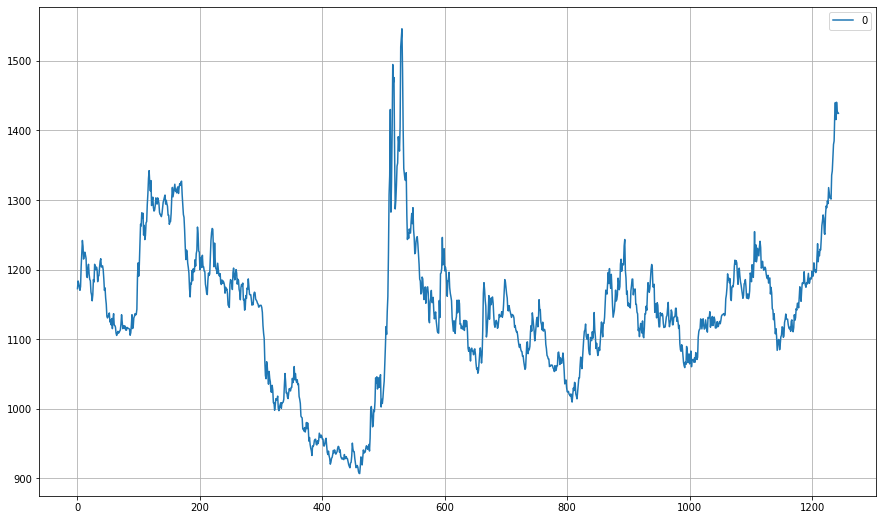

In [54]:
mydf.plot(grid=True)

### Filtering & Nomalizing Dataset

#### sklearn에서 제공하는 Scaler에는 크게 세 가지가 있음.
#### Standard, MinMax, Robust
#### 이상치가 있는 시계열 자료에 가장 적합한 것이 Robust Scaler: 3분위 값, 1분위 값 기준으로 scaling

#### Denoising Filter를 사용하여 LSTM의 학습을 용이하게.
#### Moving Average가 잘 알려져 있는데, 이 방법으로는 위 문제를 해결할 수 없음.
#### Savitzky-Golay Filter 사용

In [55]:
scaler = RobustScaler()
df_robust = scaler.fit_transform(mydf[-996:])
len(df_robust)

996

#### 계산의 편의를 위해 1000주의 데이터를 사용

In [56]:
print(df_robust.shape)
mydf.shape

(996, 1)


(1244, 1)

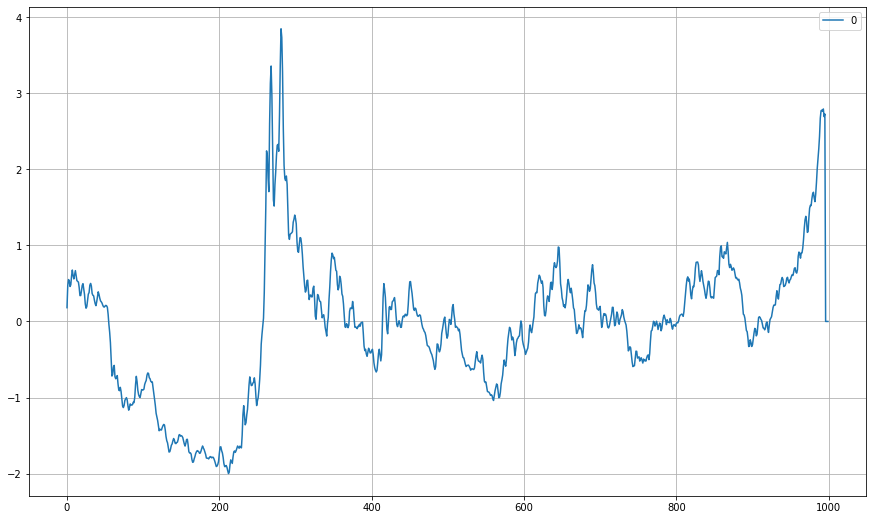

In [70]:
df_s = scipy.signal.savgol_filter(np.ravel(df_robust), 5, 3)
df_append = np.append(df_s, np.array([0, 0, 0, 0]))
mydata = pd.DataFrame(df_append)
mydata.plot(grid = True)

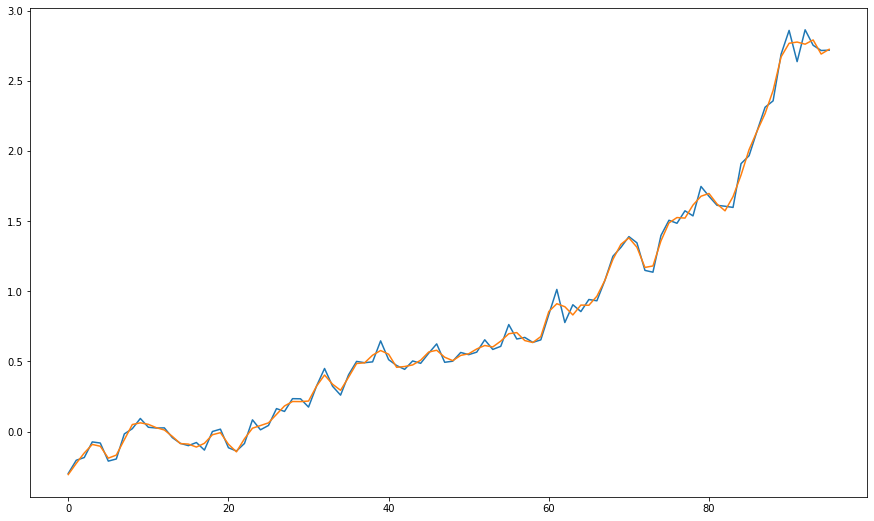

In [71]:
plt.plot(df_robust[-96:])
plt.plot(mydata[-100:-4].to_numpy())

#### Filter와 Scaler를 적용한 값 = 주황색
#### Scaler만 적용한 값 = 파란색
#### -> Filter 적용시 denoising이 일어났음을 확인할 수 있음.

## Defining Necessary Classes

#### LSTM 모형 사용: 시계열 데이터 예측에서 가장 널리 쓰이는 딥러닝 방법론

In [14]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size, dropout, use_bn):
        super(LSTM, self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.batch_size = batch_size
        self.dropout = dropout
        self.use_bn = use_bn 
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.hidden = self.init_hidden()
        self.regressor = self.make_regressor()
        
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    
    def make_regressor(self):
        layers = []
        if self.use_bn:
            layers.append(nn.BatchNorm1d(self.hidden_dim))
        layers.append(nn.Dropout(self.dropout))
        
        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim // 2))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim // 2, self.output_dim))
        regressor = nn.Sequential(*layers)
        return regressor
    
    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y_pred = self.regressor(lstm_out[-1].view(self.batch_size, -1))
        return y_pred

#### LSTM 학습에 필요한 train, validation, test 함수

In [15]:
def train(model, partition, optimizer, loss_fn, args):
    trainloader = DataLoader(partition['train'], 
                             batch_size=args.batch_size, 
                             shuffle=True, drop_last=True)
    model.train()
    model.zero_grad()
    optimizer.zero_grad()

    train_loss = 0.0
    for i, (X, y) in enumerate(trainloader):
        X = X.transpose(0, 1).float().to(args.device)
        y_true = y.float().to(args.device)

        model.zero_grad()
        optimizer.zero_grad()
        model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

        y_pred = model(X)
        loss = torch.sqrt(loss_fn(y_pred.view(-1), y_true.view(-1)))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss = train_loss / len(trainloader)
    return model, train_loss

In [16]:
def validate(model, partition, loss_fn, args):
    valloader = DataLoader(partition['val'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(valloader):
            X = X.transpose(0, 1).float().to(args.device)
            y_true = y.float().to(args.device)
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            loss = torch.sqrt(loss_fn(y_pred.view(-1), y_true.view(-1)))

            val_loss += loss.item()

    val_loss = val_loss / len(valloader)
    return val_loss

In [17]:
def test(model, partition, args):
    testloader = DataLoader(partition['test'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):

            X = X.transpose(0, 1).float().to(args.device)
            y_true = y.float().to(args.device)
            y_true1 = y_true[:,-4]
            y_true2 = y_true[:,-3]
            y_true3 = y_true[:,-2]
            y_true4 = y_true[:,-1]
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            y_pred1 = y_pred[:,-4]
            y_pred2 = y_pred[:,-3]
            y_pred3 = y_pred[:,-2]
            y_pred4 = y_pred[:,-1]
    return y_true1, y_true2, y_true3, y_true4, y_pred1, y_pred2, y_pred3, y_pred4

#### Hyperparameter Tuning을 도와줄 함수

In [18]:
def experiment(partition, args):

    model = LSTM(args.input_dim, args.hid_dim, args.y_frames, args.n_layers, args.batch_size, args.dropout, args.use_bn)
    model.to(args.device)
    loss_fn = torch.nn.MSELoss()

    loss_fn = nn.MSELoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
        
    for epoch in range(args.epoch):
        ts = time.time()
        model, train_loss = train(model, partition, optimizer, loss_fn, args)
        val_loss = validate(model, partition, loss_fn, args)
        te = time.time()
        train_acc = 0
        val_acc = 0

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print('Epoch {}, Loss(train/val) {:2.5f}/{:2.5f}. Took {:2.2f} sec'.format(epoch, train_loss, val_loss, te-ts))

    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    return vars(args), result

#### Hyperparameter Tuning 과정이 끝난 후, 최종적인 예측을 진행할 함수

In [88]:
def prediction(partition, args):

    model = LSTM(args.input_dim, args.hid_dim, args.y_frames, args.n_layers, args.batch_size, args.dropout, args.use_bn)
    model.to(args.device)
    loss_fn = torch.nn.MSELoss()

    loss_fn = nn.MSELoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    y_trues1 = []
    y_trues2 = []
    y_trues3 = []
    y_trues4 = []
    y_preds1 = []
    y_preds2 = []
    y_preds3 = []
    y_preds4 = []    
        
    for epoch in range(args.epoch):
        ts = time.time()
        model, train_loss = train(model, partition, optimizer, loss_fn, args)
        val_loss = validate(model, partition, loss_fn, args)
        y_true1, y_true2, y_true3, y_true4, y_pred1, y_pred2, y_pred3, y_pred4 = test(model, partition, args)
        te = time.time()
        train_acc = 0
        val_acc = 0

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        y_trues1.append(y_true1)
        y_trues2.append(y_true2)
        y_trues3.append(y_true3)
        y_trues4.append(y_true4)
        y_preds1.append(y_pred1)
        y_preds2.append(y_pred2)
        y_preds3.append(y_pred3)
        y_preds4.append(y_pred4)
        
        print('Epoch {}, Loss(train/val) {:2.5f}/{:2.5f}. Took {:2.2f} sec'.format(epoch, train_loss, val_loss, te-ts))

    for i in range(len(y_trues1)):
        y_trues1[i] = [item for sublist in y_trues1[i] for item in sublist]
    for i in range(len(y_trues2)):
        y_trues2[i] = [item for sublist in y_trues2[i] for item in sublist]
    for i in range(len(y_trues3)):
        y_trues3[i] = [item for sublist in y_trues3[i] for item in sublist]
    for i in range(len(y_trues4)):
        y_trues4[i] = [item for sublist in y_trues4[i] for item in sublist]

    trues_plots1 = []
    trues_plots2 = []
    trues_plots3 = []
    trues_plots4 = []
    preds_plots1 = []
    preds_plots2 = []
    preds_plots3 = []
    preds_plots4 = []

    for i in range(len(y_preds1[-1])):
        preds_plots1.append(y_preds1[-1][i])
    for i in range(len(y_preds2[-1])):
        preds_plots2.append(y_preds2[-1][i])
    for i in range(len(y_preds3[-1])):
        preds_plots3.append(y_preds3[-1][i])
    for i in range(len(y_preds4[-1])):
        preds_plots4.append(y_preds4[-1][i]) 

    for i in range(len(y_trues1[-1])):
        trues_plots1.append(y_trues1[-1][i])
    for i in range(len(y_trues2[-1])):
        trues_plots2.append(y_trues2[-1][i])
    for i in range(len(y_trues3[-1])):
        trues_plots3.append(y_trues3[-1][i])
    for i in range(len(y_trues4[-1])):
        trues_plots4.append(y_trues4[-1][i])
    
    pp1 = scaler.inverse_transform(np.array(preds_plots1).reshape(-1, 1))
    pp2 = scaler.inverse_transform(np.array(preds_plots2).reshape(-1, 1))
    pp3 = scaler.inverse_transform(np.array(preds_plots3).reshape(-1, 1))
    pp4 = scaler.inverse_transform(np.array(preds_plots4).reshape(-1, 1))
    tp1 = scaler.inverse_transform(np.array(trues_plots1).reshape(-1, 1))
    tp2 = scaler.inverse_transform(np.array(trues_plots2).reshape(-1, 1))
    tp3 = scaler.inverse_transform(np.array(trues_plots3).reshape(-1, 1))
    tp4 = scaler.inverse_transform(np.array(trues_plots4).reshape(-1, 1))
    plt.figure(figsize = (16, 36))
    plt.subplot(4, 1, 1)
    plt.plot(pp1, 'b-', pp1, 'bo', markersize = 1, label = '1st Week Predictions')
    plt.plot(tp1[:-2], 'r-', tp1[:-2], 'ro', markersize = 1, label = '1st Week Trues')
    plt.plot(mydf.values[-192:], 'y-', mydf.values[-192:], 'yo', markersize = 1, label = '1st Week Reals')
    
    plt.subplot(4, 1, 2)
    plt.plot(pp2, 'b-', pp2, 'bo', markersize = 1, label = '2nd Week Predictions')
    plt.plot(tp2[:-3], 'r-', tp2[:-3], 'ro', markersize = 1, label = '2nd Week Trues')
    plt.plot(mydf.values[-191:], 'y-', mydf.values[-191:], 'yo', markersize = 1, label = '2nd Week Reals')
    
    plt.subplot(4, 1, 3)
    plt.plot(pp3, 'b-', pp3, 'bo', markersize = 1, label = '3rd Week Predictions')
    plt.plot(tp3[:-4], 'r-', tp3[:-4], 'ro', markersize = 1, label = '3rd Week Trues')
    plt.plot(mydf.values[-190:], 'y-', mydf.values[-190:], 'yo', markersize = 1, label = '3rd Week Reals')
    
    plt.subplot(4, 1, 4)
    plt.plot(pp4, 'b-', pp4, 'bo', markersize = 1, label = '4th Week Predictions')
    plt.plot(tp4[:-5], 'r-', tp4[:-5], 'ro', markersize = 1, label = '4th Week Trues')
    plt.plot(mydf.values[-189:], 'y-', mydf.values[-189:], 'yo', markersize = 1, label = '4th Week Reals')
    
    print('-4주차 실제값, Filter 처리값, 예측값: ', mydf.values[-4], tp1[-5], pp1[-5])
    print('-3주차 실제값, Filter 처리값, 예측값: ', mydf.values[-3], tp2[-5], pp2[-5])
    print('-2주차 실제값, Filter 처리값, 예측값: ', mydf.values[-2], tp3[-5], pp3[-5])
    print('-1주차 실제값, Filter 처리값, 예측값: ', mydf.values[-1], tp4[-5], pp4[-5])
    print('1주차 예측값: ', pp1[-1])
    print('2주차 예측값: ', pp2[-1])
    print('3주차 예측값: ', pp3[-1])
    print('4주차 예측값: ', pp4[-1])

    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    return vars(args), result

#### Hyperparameter Tuning 결과를 저장 및 불러오기

In [20]:
import os

new_dir_path = 'results1028'

os.mkdir(new_dir_path)

In [21]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = 'results1028/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = 'results1028'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

#### 저장된 결과를 시각화 해줄 함수

In [22]:
def plot_loss_variation(var1, df, **kwargs):

    list_v1 = df[var1].unique()
    list_data = []

    for value1 in list_v1:
        row = df.loc[df[var1]==value1]
        train_losses = list(row.train_losses)[0]
        val_losses = list(row.val_losses)[0]

        for epoch, train_loss in enumerate(train_losses):
            list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1})
        for epoch, val_loss in enumerate(val_losses):
            list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89)

def plot_loss_variation2(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89)

def plot_ypred_ytrue(var3, var4, df, **kwargs):

    list_ypred = df[var3].unique()
    list_ytrue = df[var4].unique()
    list_data = []

    for valuep in list_ypred:
        for valuet in list_ytrue:
            row = df.loc[df[var3]==valuep]
            row = row.loc[df[var4]==valuet]

            y_preds = list(row.y_preds)[0]
            y_trues = list(row.y_trues)[0]

            for epoch, y_pred in enumerate(y_preds):
                list_data.append({'type':'y_pred', 'pred':y_pred, 'epoch':epoch, var3:valuep, var4:valuet})
            for epoch, y_true in enumerate(y_trues):
                list_data.append({'type':'y_true', 'loss':y_true, 'epoch':epoch, var3:valuep, var4:valuet})

## Hyperparameter Tuning

### 1. Optimizer

In [ ]:
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_optim0"
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

args.batch_size = 193
args.x_frames = 4
args.y_frames = 4
trainset = MyDataset(args.x_frames, args.y_frames, mydata, 0, int(0.6*len(mydata)))
valset = MyDataset(args.x_frames, args.y_frames, mydata, int(0.6*len(mydata)), int(0.8*len(mydata)))
testset = MyDataset(args.x_frames, args.y_frames, mydata, int(0.8*len(mydata)), int(len(mydata)))
partition = {'train': trainset, 'val':valset, 'test':testset}


args.input_dim = 1
args.hid_dim = 8
args.n_layers = 4

args.l2 = 0.00001
args.dropout = 0.0
args.use_bn = True

args.optim = 'Adam'
args.lr = 0.0001
args.epoch = 200

name_var1 = 'optim'
list_var1 = ['SGD', 'RMSprop', 'Adam', 'Adagrad']

for var1 in list_var1:
    setattr(args, name_var1, var1)
    print(args)
                
    setting, result = experiment(partition, deepcopy(args))
    save_exp_result(setting, result)

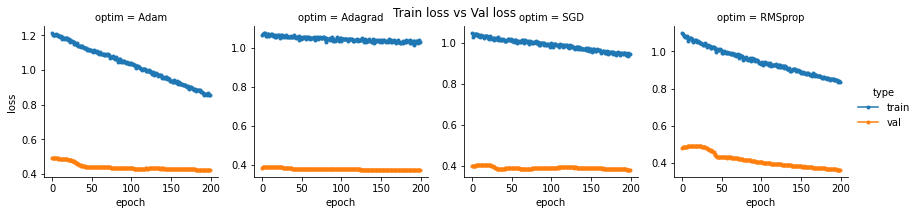

In [75]:
var1 = 'optim'
df = load_exp_result('exp1_optim0')

plot_loss_variation(var1, df, sharey=False)

## Result
### optim = Adam

# 2. Model Capacity

In [ ]:
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp2_hidn0"
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

args.batch_size = 193
args.x_frames = 4
args.y_frames = 4
trainset = MyDataset(args.x_frames, args.y_frames, mydata, 0, int(0.6*len(mydata)))
valset = MyDataset(args.x_frames, args.y_frames, mydata, int(0.6*len(mydata)), int(0.8*len(mydata)))
testset = MyDataset(args.x_frames, args.y_frames, mydata, int(0.8*len(mydata)), int(len(mydata)))
partition = {'train': trainset, 'val':valset, 'test':testset}

args.input_dim = 1
args.hid_dim = 8
args.n_layers = 4

args.l2 = 0.00001
args.dropout = 0.0
args.use_bn = True

args.optim = 'Adam'
args.lr = 0.00005
args.epoch = 2000

name_var1 = 'hid_dim'
name_var2 = 'n_layers'
list_var1 = [4, 8, 16, 32, 64]
list_var2 = [2, 4, 6, 8]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

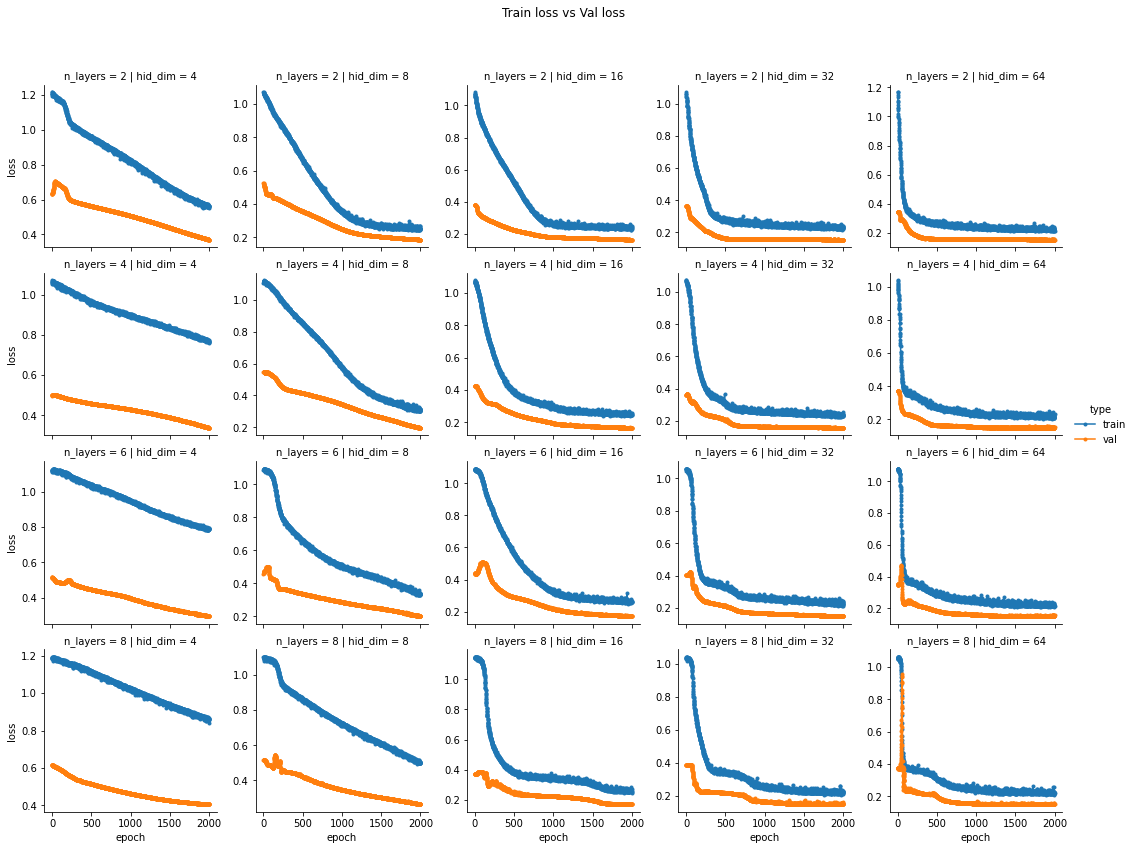

In [78]:
var1 = 'hid_dim'
var2 = 'n_layers'
df = load_exp_result('exp2_hidn0')

plot_loss_variation2(var1, var2, df, sharey=False)

## Results
### hid_dim = 16
### n_layers = 8

## 3. Learning Rate(lr)

In [ ]:
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp3_lr0"
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

args.batch_size = 193
args.x_frames = 4
args.y_frames = 4
trainset = MyDataset(args.x_frames, args.y_frames, mydata, 0, int(0.6*len(mydata)))
valset = MyDataset(args.x_frames, args.y_frames, mydata, int(0.6*len(mydata)), int(0.8*len(mydata)))
testset = MyDataset(args.x_frames, args.y_frames, mydata, int(0.8*len(mydata)), int(len(mydata)))
partition = {'train': trainset, 'val':valset, 'test':testset}

args.input_dim = 1
args.hid_dim = 16
args.n_layers = 8

args.l2 = 0.00001
args.dropout = 0.0
args.use_bn = True

args.optim = 'Adam'
args.lr = 0.0001
args.epoch = 3000

name_var1 = 'lr'
list_var1 = [0.00001, 0.00003, 0.00005, 0.00007, 0.00009]

for var1 in list_var1:
    setattr(args, name_var1, var1)
    print(args)
                
    setting, result = experiment(partition, deepcopy(args))
    save_exp_result(setting, result)

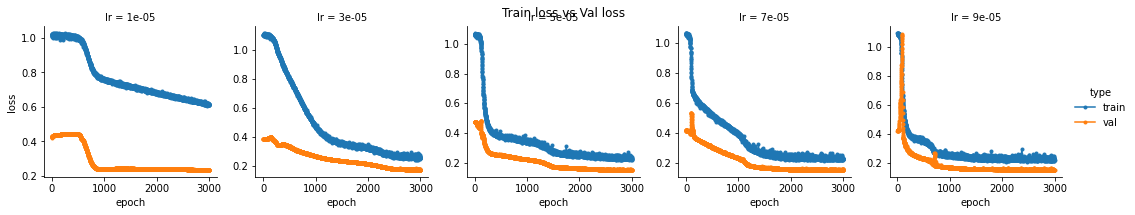

In [80]:
var1 = 'lr'
df = load_exp_result('exp3_lr0')

plot_loss_variation(var1, df, sharey=False)

In [ ]:
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp3_lr_deep0"
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

args.batch_size = 193
args.x_frames = 4
args.y_frames = 4
trainset = MyDataset(args.x_frames, args.y_frames, mydata, 0, int(0.6*len(mydata)))
valset = MyDataset(args.x_frames, args.y_frames, mydata, int(0.6*len(mydata)), int(0.8*len(mydata)))
testset = MyDataset(args.x_frames, args.y_frames, mydata, int(0.8*len(mydata)), int(len(mydata)))
partition = {'train': trainset, 'val':valset, 'test':testset}

args.input_dim = 1
args.hid_dim = 16
args.n_layers = 8

args.l2 = 0.00001
args.dropout = 0.0
args.use_bn = True

args.optim = 'Adam'
args.lr = 0.0001
args.epoch = 3500

name_var1 = 'lr'
list_var1 = [0.00002, 0.00003, 0.00004]

for var1 in list_var1:
    setattr(args, name_var1, var1)
    print(args)
                
    setting, result = experiment(partition, deepcopy(args))
    save_exp_result(setting, result)

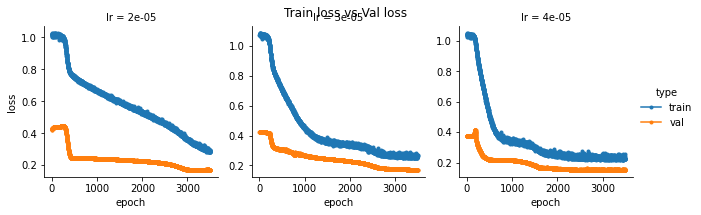

In [82]:
var1 = 'lr'
df = load_exp_result('exp3_lr_deep0')

plot_loss_variation(var1, df, sharey=False)

## Results
### lr = 0.00003

## 4. L2 norm(l2)

In [ ]:
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp4_l20"
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

args.batch_size = 193
args.x_frames = 4
args.y_frames = 4
trainset = MyDataset(args.x_frames, args.y_frames, mydata, 0, int(0.6*len(mydata)))
valset = MyDataset(args.x_frames, args.y_frames, mydata, int(0.6*len(mydata)), int(0.8*len(mydata)))
testset = MyDataset(args.x_frames, args.y_frames, mydata, int(0.8*len(mydata)), int(len(mydata)))
partition = {'train': trainset, 'val':valset, 'test':testset}

args.input_dim = 1
args.hid_dim = 16
args.n_layers = 8

args.l2 = 0.00001
args.dropout = 0.0
args.use_bn = True

args.optim = 'Adam'
args.lr = 0.00003
args.epoch = 3800

name_var1 = 'l2'
list_var1 = [0.00001, 0.0001, 0.001, 0.01, 0.1]

for var1 in list_var1:
    setattr(args, name_var1, var1)
    print(args)
                
    setting, result = experiment(partition, deepcopy(args))
    save_exp_result(setting, result)

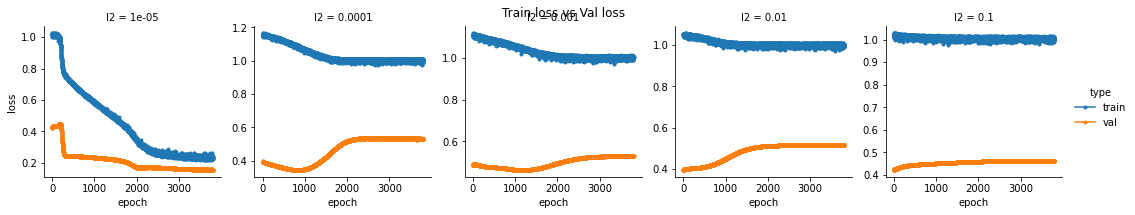

In [84]:
var1 = 'l2'
df = load_exp_result('exp4_l20')

plot_loss_variation(var1, df, sharey=False)

## Results
### l2 = 0.00001

## 5. Dropout

In [ ]:
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp5_dropout0"
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

args.batch_size = 193
args.x_frames = 4
args.y_frames = 4
trainset = MyDataset(args.x_frames, args.y_frames, mydata, 0, int(0.6*len(mydata)))
valset = MyDataset(args.x_frames, args.y_frames, mydata, int(0.6*len(mydata)), int(0.8*len(mydata)))
testset = MyDataset(args.x_frames, args.y_frames, mydata, int(0.8*len(mydata)), int(len(mydata)))
partition = {'train': trainset, 'val':valset, 'test':testset}

args.input_dim = 1
args.hid_dim = 16
args.n_layers = 8

args.l2 = 0.00001
args.dropout = 0.0
args.use_bn = True

args.optim = 'Adam'
args.lr = 0.00003
args.epoch = 3800

name_var1 = 'dropout'
list_var1 = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

for var1 in list_var1:
    setattr(args, name_var1, var1)
    print(args)
                
    setting, result = experiment(partition, deepcopy(args))
    save_exp_result(setting, result)

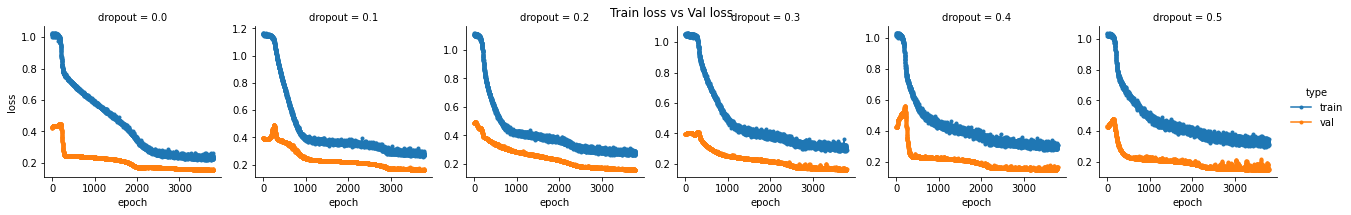

In [86]:
var1 = 'dropout'
df = load_exp_result('exp5_dropout0')

plot_loss_variation(var1, df, sharey=False)

## Results
### dropout = 0.0

# Prediction

Namespace(batch_size=193, device='cpu', dropout=0.0, epoch=3800, exp_name='exp0_test', hid_dim=16, input_dim=1, l2=1e-05, lr=3e-05, n_layers=8, optim='Adam', use_bn=True, x_frames=4, y_frames=4)
Epoch 0, Loss(train/val) 1.02363/0.42191. Took 0.09 sec
Epoch 1, Loss(train/val) 1.01481/0.42331. Took 0.07 sec
Epoch 2, Loss(train/val) 1.02062/0.42453. Took 0.07 sec
Epoch 3, Loss(train/val) 1.01169/0.42559. Took 0.07 sec
Epoch 4, Loss(train/val) 1.02274/0.42651. Took 0.07 sec
Epoch 5, Loss(train/val) 1.02027/0.42732. Took 0.08 sec
Epoch 6, Loss(train/val) 1.02462/0.42804. Took 0.07 sec
Epoch 7, Loss(train/val) 1.02339/0.42866. Took 0.07 sec
Epoch 8, Loss(train/val) 1.02091/0.42922. Took 0.07 sec
Epoch 9, Loss(train/val) 1.01820/0.42971. Took 0.07 sec
Epoch 10, Loss(train/val) 1.02473/0.43016. Took 0.07 sec
Epoch 11, Loss(train/val) 1.01483/0.43057. Took 0.08 sec
Epoch 12, Loss(train/val) 1.02215/0.43095. Took 0.08 sec
Epoch 13, Loss(train/val) 1.01872/0.43130. Took 0.08 sec
Epoch 14, Loss(tr

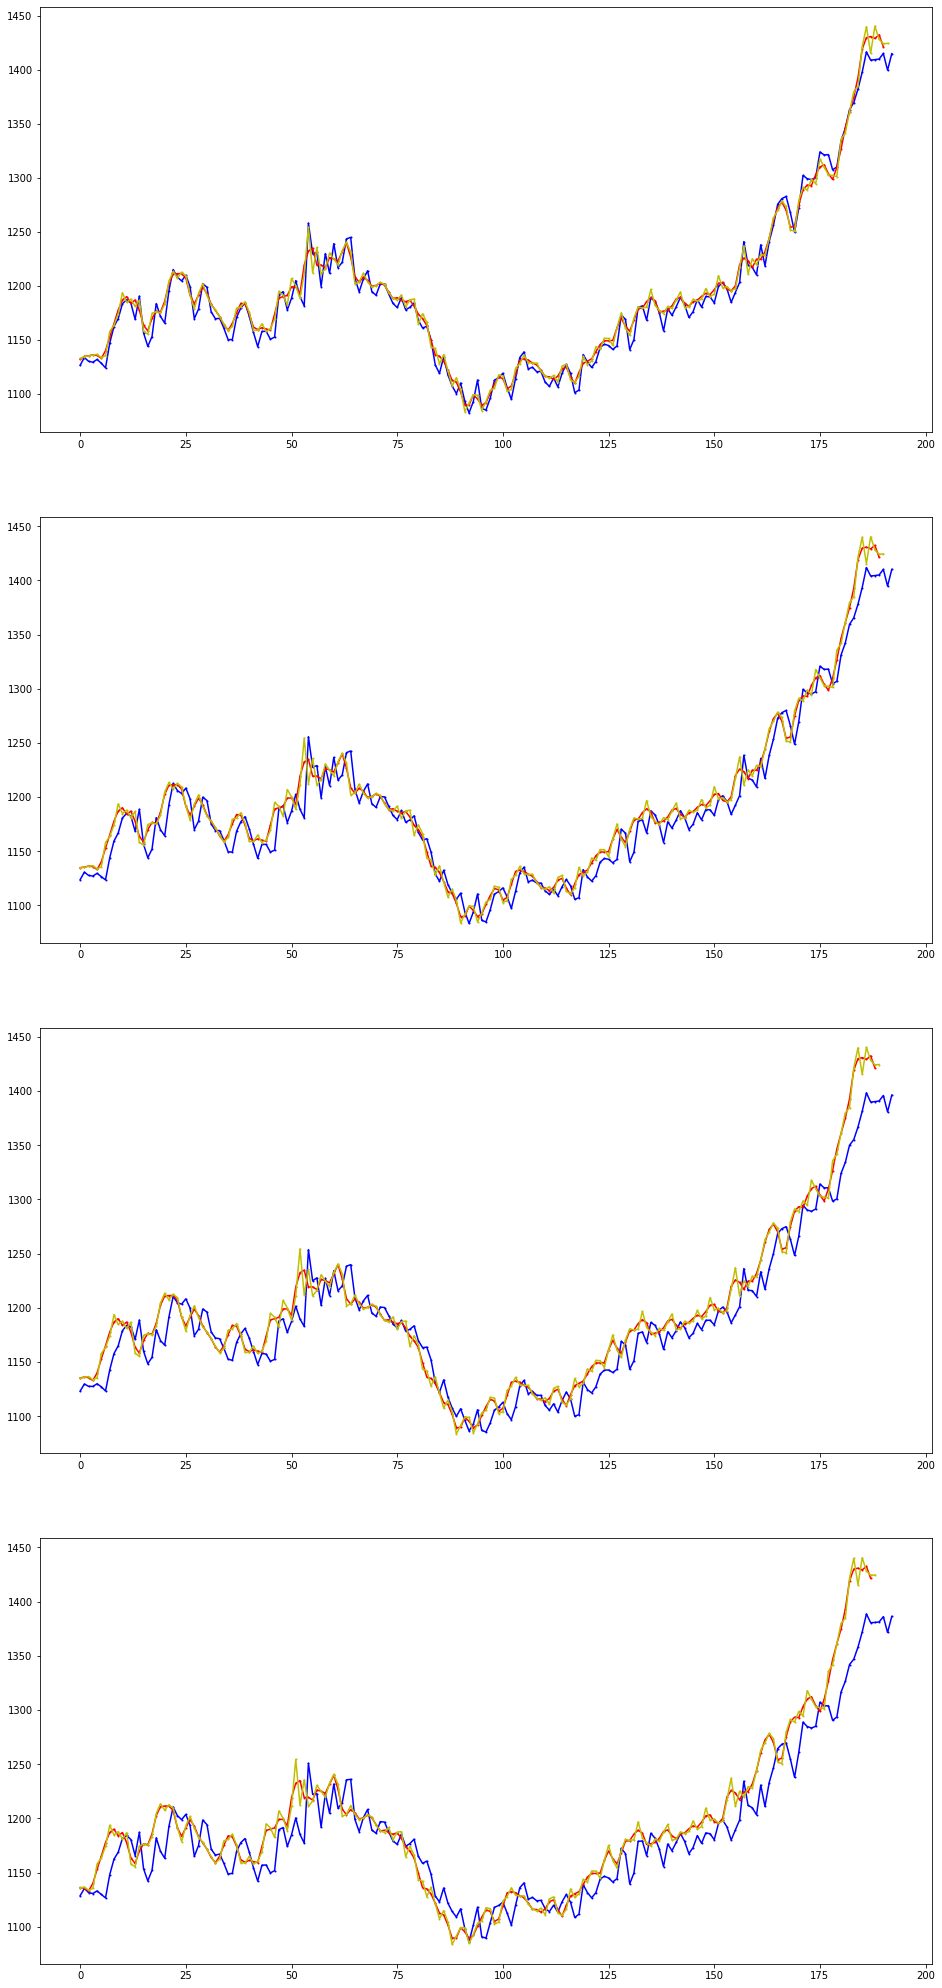

In [89]:
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp0_test"
args.device = 'cpu'

args.batch_size = 193
args.x_frames = 4
args.y_frames = 4
trainset = MyDataset(args.x_frames, args.y_frames, mydata, 0, int(0.6*len(mydata)))
valset = MyDataset(args.x_frames, args.y_frames, mydata, int(0.6*len(mydata)), int(0.8*len(mydata)))
testset = MyDataset(args.x_frames, args.y_frames, mydata, int(0.8*len(mydata)), int(len(mydata)))
partition = {'train': trainset, 'val':valset, 'test':testset}

args.input_dim = 1
args.hid_dim = 16
args.n_layers = 8

args.l2 = 0.00001
args.dropout = 0.0
args.use_bn = True

args.optim = 'Adam'
args.lr = 0.00003
args.epoch = 3800

name_var1 = 'hid_dim'
list_var1 = [16]

for var1 in list_var1:
    setattr(args, name_var1, var1)
    print(args)
                
    setting, result = prediction(partition, deepcopy(args))
    save_exp_result(setting, result)